In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
from ecco_v4_py import vector_calc, scalar_calc

import gsw
import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr

In [2]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [3]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [4]:
# function for determining the memory footprint of an object

# ... from https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [5]:
ecco_v4r5_mon_mean_native_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_dir.glob('*')))
# Select a dataset (the one containing temperature and salinity)
dataset_num = 20

print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num])
TS_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]

# make a list of all of the files in the directory
TS_dataset_files = np.sort(list(TS_dataset_dir.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in TS_dataset_files[:5]])

# Select a dataset (the one containing temperature and salinity)
dataset_num = 22

print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num])
Vel_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]

# make a list of all of the files in the directory
Vel_dataset_files = np.sort(list(Vel_dataset_dir.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in Vel_dataset_files[:5]])

# Select a dataset (the one containing temperature and salinity)
dataset_num = 16

print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num])
dens_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num]

# make a list of all of the files in the directory
dens_dataset_files = np.sort(list(dens_dataset_dir.glob('*nc')))

# show first 5 files
print('\nFirst 5 files')
pprint([x.name for x in dens_dataset_files[:5]])

selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY

First 5 files
['OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-02_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-03_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-04_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-05_ECCO_V4r5_native_llc0090.nc']
selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_VOLUME_FLUX

First 5 files
['OCEAN_VOLUME_FLUX_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_VOLUME_FLUX_mon_mean_1992-02_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_VOLUME_FLUX_mon_mean_1992-03_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_VOLUME_FLUX_mon_mean_1992-04_ECCO_V4r5_native_llc0090.nc',
 'OCEAN_VOLUME_FLUX_mon_mean_1992-05_ECCO_V4r5_native_llc0090.nc']
selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_DENS_STRAT_PRESS

First 5 files
['OCEAN_DE

In [6]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:45545") #find within Scheduler Address with orange red squares)
client.ncores
client.restart()

In [7]:
start_time = time.time();
ds_TS = None
ds_vel = None

files_to_load = TS_dataset_files

print(f'lazy-loading {len(files_to_load)} granules')
# first lazy load
ds_TS = xr.open_mfdataset(TS_dataset_files, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})

files_to_load = Vel_dataset_files

print(f'lazy-loading {len(files_to_load)} granules')
# first lazy load
ds_vel = xr.open_mfdataset(Vel_dataset_files, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})
files_to_load = dens_dataset_files

print(f'lazy-loading {len(files_to_load)} granules')
# first lazy load
ds_dens = xr.open_mfdataset(dens_dataset_files, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})


total_time = time.time() - start_time

lazy-loading 336 granules
lazy-loading 336 granules
lazy-loading 336 granules


In [8]:
# take mean temperature in the uppermost grid cell over all times
st = time.time()

T_mean_k0 = ds_TS.THETA.isel(k=0).mean(dim='time').compute()

total_time = time.time() - st
print(f'total time to compute the mean temperature {total_time:.3g}s')


total time to compute the mean temperature 23.3s


Text(0.5, 1.0, 'Mean Ocean Temperature from 0-10m : 1992-01-01 to 2019-12-31 ')

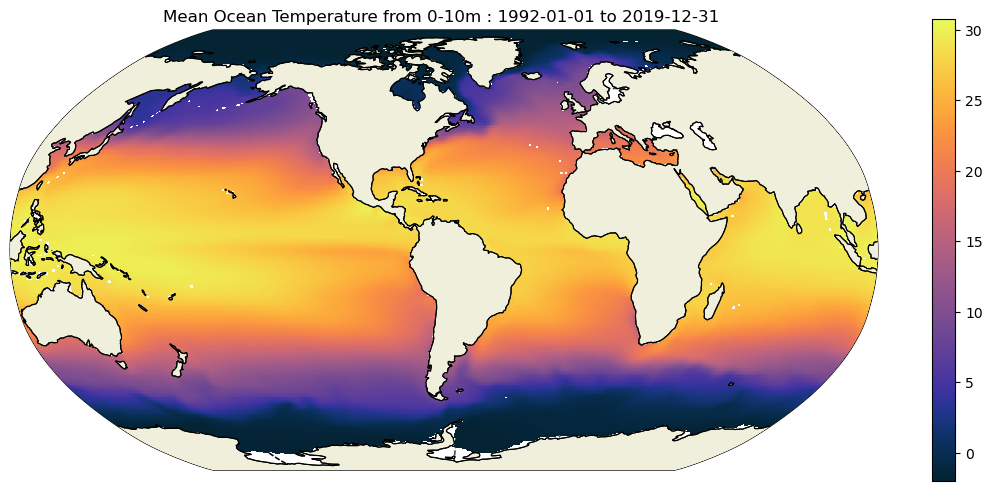

In [9]:
plt.figure(figsize=[14,6]);

ecco.plot_proj_to_latlon_grid(T_mean_k0.XC, T_mean_k0.YC, 
                              T_mean_k0, 
                              user_lon_0=-67, show_colorbar=True,
                              cmin=-2, cmax=T_mean_k0.max(), 
                              cmap=cmocean.cm.thermal);

plt.title(f'Mean Ocean Temperature from 0-10m : {str(ds_TS.time_bnds[0][0].values)[:10]} to ' +
                    f'{str(ds_TS.time_bnds[-1][-1].values)[:10]} ')

In [23]:
ds_dens

<xarray.Dataset> Size: 28GB
Dimensions:    (time: 336, k: 50, tile: 13, j: 90, i: 90, k_l: 50, i_g: 90,
                j_g: 90, k_u: 50, k_p1: 51, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 5kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    RHOAnoma   (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
    DRHODR     (time, k_l, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
    PHIHYD     (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
    PHIHYDcR   (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Density, Stratification, and ...
    uuid:                            019486da-2718-11f0-9482-0a58a9feac02

In [24]:
pres = ds_dens.PHIHYD

In [9]:
ds_short = ds_TS.isel(time=1)

In [82]:
import xarray as xr
ds = xr.open_dataset('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY/OCEAN_TEMPERATURE_SALINITY_mon_mean_1992-07_ECCO_V4r5_native_llc0090.nc')

In [84]:
ds.data_vars

Data variables:
    THETA    (time, k, tile, j, i) float32 21MB ...
    SALT     (time, k, tile, j, i) float32 21MB ...

(<Figure size 900x900 with 25 Axes>,
 array([[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]]))

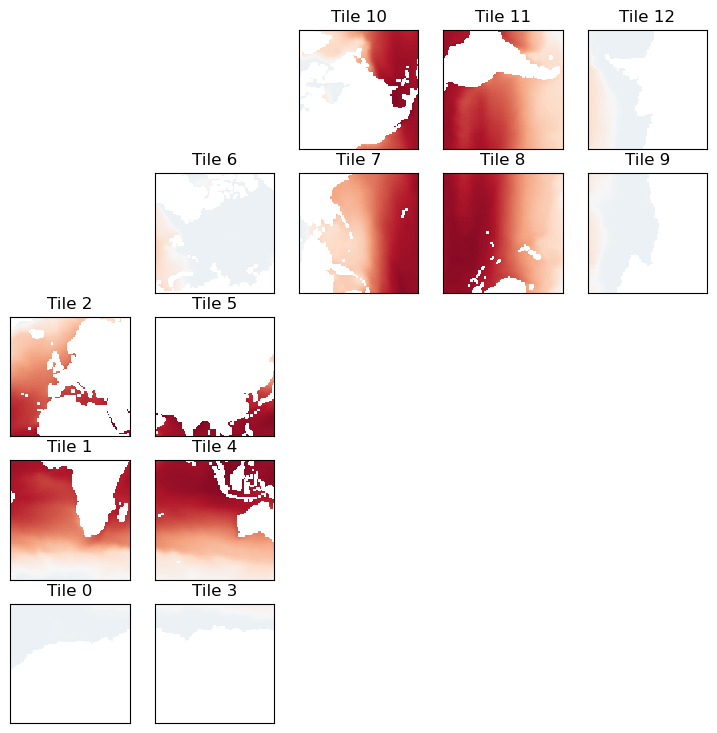

In [85]:
ecco.plot_tiles(ds['THETA'][0,0,:])

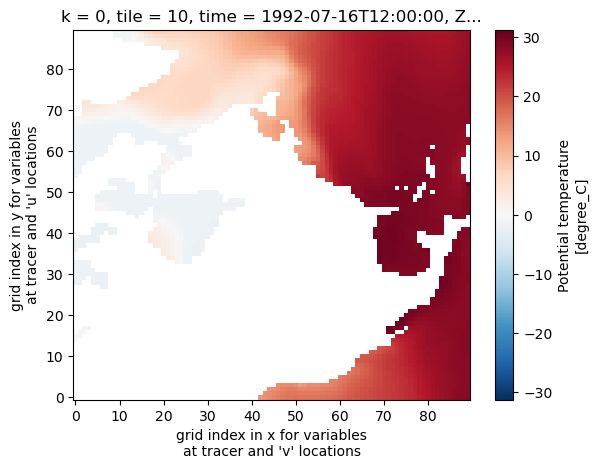

In [87]:
ds['THETA'][0,0,10].plot()

In [92]:
tile_i_care_about = ds['THETA'][0,:,10]
print(tile_i_care_about.shape)
print(tile_i_care_about.dims)
tile_i_care_about.XC[:,52].values

(50, 90, 90)
('k', 'j', 'i')


array([-127.5, -126.5, -125.5, -124.5, -123.5, -122.5, -121.5, -120.5,
       -119.5, -118.5, -117.5, -116.5, -115.5, -114.5, -113.5, -112.5,
       -111.5, -110.5, -109.5, -108.5, -107.5, -106.5, -105.5, -104.5,
       -103.5, -102.5, -101.5, -100.5,  -99.5,  -98.5,  -97.5,  -96.5,
        -95.5,  -94.5,  -93.5,  -92.5,  -91.5,  -90.5,  -89.5,  -88.5,
        -87.5,  -86.5,  -85.5,  -84.5,  -83.5,  -82.5,  -81.5,  -80.5,
        -79.5,  -78.5,  -77.5,  -76.5,  -75.5,  -74.5,  -73.5,  -72.5,
        -71.5,  -70.5,  -69.5,  -68.5,  -67.5,  -66.5,  -65.5,  -64.5,
        -63.5,  -62.5,  -61.5,  -60.5,  -59.5,  -58.5,  -57.5,  -56.5,
        -55.5,  -54.5,  -53.5,  -52.5,  -51.5,  -50.5,  -49.5,  -48.5,
        -47.5,  -46.5,  -45.5,  -44.5,  -43.5,  -42.5,  -41.5,  -40.5,
        -39.5,  -38.5], dtype=float32)

In [94]:
face_of_t_that_i_care_about = tile_i_care_about[:,:,52]
face_of_t_that_i_care_about

<xarray.DataArray 'THETA' (k: 50, j: 90)> Size: 18kB
[4500 values with dtype=float32]
Coordinates:
    i        int32 4B 52
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    tile     int32 4B 10
    time     datetime64[ns] 8B 1992-07-16T12:00:00
    XC       (j) float32 360B ...
    YC       (j) float32 360B ...
    Z        (k) float32 200B ...
Attributes:
    valid_min:              -2.7571568
    valid_max:              33.054157
    coverage_content_type:  modelResult
    long_name:              Potential temperature 
    standard_name:          sea_water_potential_temperature
    units:                  degree_C
    comment:                Sea water potential temperature is the temperatur...

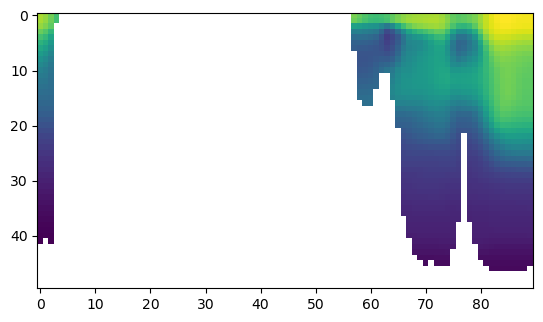

In [95]:
plt.imshow(face_of_t_that_i_care_about)

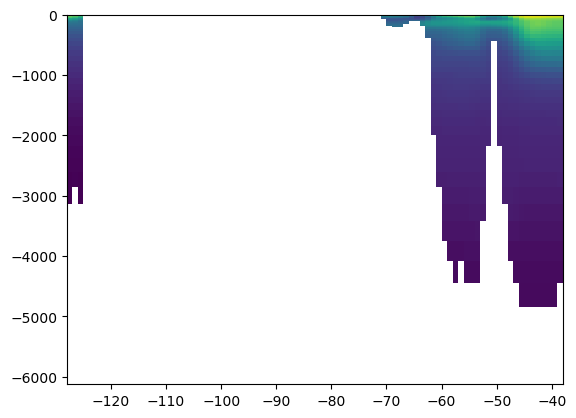

In [96]:
plt.pcolormesh(face_of_t_that_i_care_about.XC, face_of_t_that_i_care_about.Z, face_of_t_that_i_care_about)

In [99]:
ds['THETA'].dims

('time', 'k', 'tile', 'j', 'i')

In [131]:
nlon_centers, nlat_centers, nlone, nlate, T_reg = \
    ecco.resample_to_latlon(ds_tmp2.XC, ds_tmp2.YC, 
                            ds['THETA'][0][0], -90, 90,
                            0.2, -180, 180, 0.2, 
                            radius_of_influence=200000.0,
                            mapping_method='nearest_neighbor')

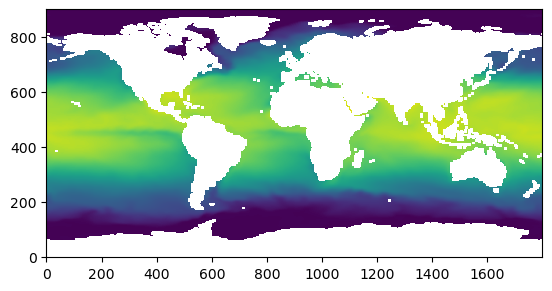

In [132]:
plt.imshow(T_reg, origin='lower')

In [137]:
T_latlon_beast = []
for k in range(50):
    nlon_centers, nlat_centers, nlone, nlate, T_reg = \
        ecco.resample_to_latlon(ds_tmp2.XC, ds_tmp2.YC, 
                                ds['THETA'][0][k], -90, 90,
                                0.2, -180, 180, 0.2, 
                                radius_of_influence=200000.0,
                                mapping_method='nearest_neighbor')
    T_latlon_beast.append(T_reg)

In [148]:
j_tokyo = np.argmax(nlat_centers[:,0] >= 36.5)
nlat_centers[j_tokyo,0]
print(f'find godzilla at ', j_tokyo)

find godzilla at  632


In [147]:
T_latlon_beast = np.array(T_latlon_beast)
T_latlon_beast

array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.9453455, -1.9453455, -1.9453455, ..., -1.9453455,
         -1.9453455, -1.9453455],
        [-1.9459356, -1.9459356, -1.9459356, ..., -1.9459356,
         -1.9459356, -1.9459356],
        [-1.9459356, -1.9459356, -1.9459356, ..., -1.9459356,
         -1.9459356, -1.9459356]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.9398398, -1.9398398, -1.9398398, ..., -1.9398398,
         -1.9398398, -1.9398398],
        [-1.

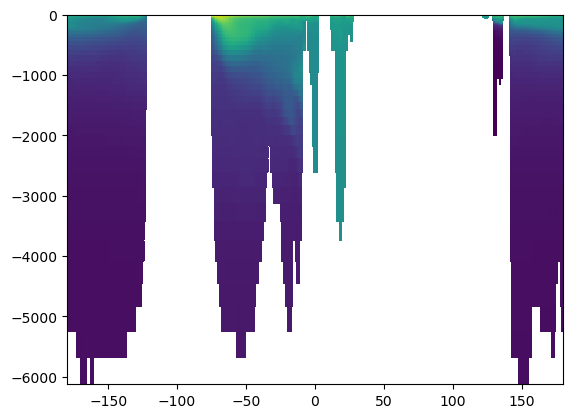

In [155]:
plt.pcolor(nlon_centers[0,:], ds.Z, T_latlon_beast[:, j_tokyo,:])


In [26]:
ds_TS

<xarray.Dataset> Size: 14GB
Dimensions:    (time: 336, k: 50, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90,
                k_u: 50, k_l: 50, k_p1: 51, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 5kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    THETA      (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
    SALT       (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            8a5175e0-2719-11f0-9a28-0a58a9feac02

In [47]:
ds_short = ds_TS.isel(time=0)

In [8]:
ds_TS

<xarray.Dataset> Size: 14GB
Dimensions:    (time: 336, k: 50, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90,
                k_u: 50, k_l: 50, k_p1: 51, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 5kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    THETA      (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
    SALT       (time, k, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            8a5175e0-2719-11f0-9a28-0a58a9feac02

In [11]:
abs_sal = ds_TS.SALT

In [10]:
cons_temp = gsw.conversions.CT_from_pt(ds_TS.SALT, ds_TS.THETA)

In [ ]:
cons_temp = gsw.conversions.CT_from_pt(abs_sal, ds_TS.THETA)

In [14]:
sigma_2 = gsw.density.sigma2(abs_sal, cons_temp)
sigma_2 = sigma_2.to_dataset(name = 'SIG2')
sigma_2

<xarray.Dataset> Size: 14GB
Dimensions:  (i: 90, j: 90, k: 50, tile: 13, time: 336)
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
    XC       (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC       (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z        (k) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
Data variables:
    SIG2     (time, k, tile, j, i) float64 14GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>

In [18]:
sigma_2.max()

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    SIG2     float64 8B 38.73

In [26]:
sig_2_star = [
sig_2_star

array([17.7827941 , 18.05221978, 18.3257275 , 18.60337912, 18.88523742,
       19.17136613, 19.46182995, 19.75669456, 20.05602665, 20.35989389,
       20.668365  , 20.98150973, 21.29939889, 21.62210436, 21.94969912,
       22.28225724, 22.61985392, 22.9625655 , 23.31046948, 23.66364452,
       24.02217049, 24.38612846, 24.75560072, 25.13067083, 25.51142359,
       25.89794511, 26.29032279, 26.68864535, 27.09300286, 27.50348676,
       27.92018987, 28.34320641, 28.77263205, 29.20856387, 29.65110047,
       30.1003419 , 30.55638975, 31.01934714, 31.48931877, 31.96641089,
       32.45073141, 32.94238982, 33.44149731, 33.94816674, 34.46251267,
       34.98465142, 35.51470105, 36.05278142, 36.5990142 , 37.15352291])

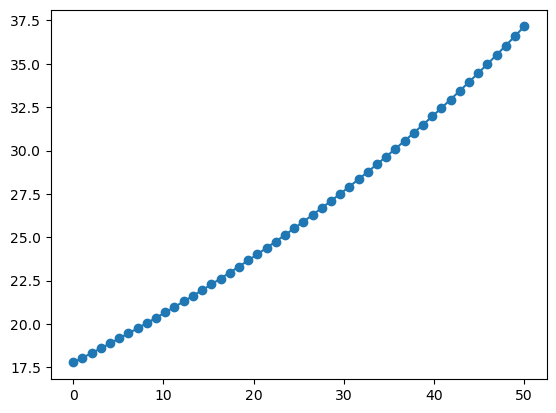

In [25]:
plt.plot(np.linspace(0,50,50),sig_2_star, '-o')

In [15]:
sigma_2 = sigma_2.load()

In [16]:
sigma_2.to_netcdf('Sigma_2_field.nc')

Text(0.5, 1.0, 'Mean Ocean Density from 0-10m 01-1992')

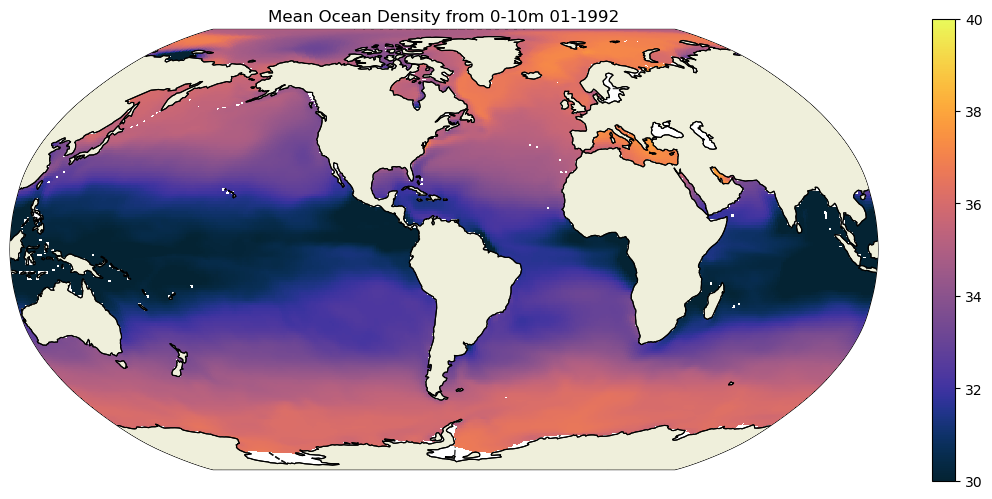

In [30]:
plt.figure(figsize=[14,6]);

ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC, 
                              sigma_2[0,:,:,:], 
                              user_lon_0=-67, show_colorbar=True,
                              cmin=30, cmax=40, 
                              cmap=cmocean.cm.thermal);

plt.title('Mean Ocean Density from 0-10m 01-1992')

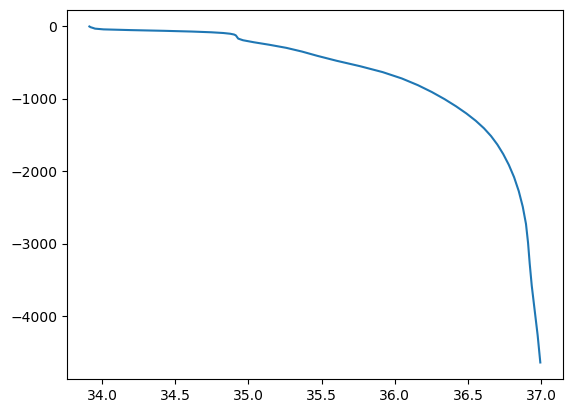

In [25]:
plt.plot(sigma_2[:,1,30,45],ds_short.Z.values)

In [10]:
geom_path = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_geom = xr.open_dataset(geom_path)

In [9]:
ds_geom

<xarray.Dataset> Size: 92MB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2)
Coordinates: (12/20)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zp1                     (k_p1) float32 204B ...
    Zu                      (k_u) float32 200B ...
    Zl                      (k_l) float32 200B ...
    XC_bnds                 (tile, j, i, nbh) float32 2MB ...
    YC_bnds                 (tile, j, i, nbh) float32 2MB ...
    Z_bnds                  (k, nv) float32 400B ...
Dimensions without coordinates: nbh, nv
Data variables: (12/29)
    CS                      (tile, j, i) float32 421kB ...
    SN                      (tile, j, i) float32 421kB ...
    rA                      (tile, j, i) float32 421kB ...
    dxG                     (tile, j_g, i) float32 421kB ...
    dyG                     (tile, j, i_g) float32 421kB ...
    Depth                   (tile, j, i) float32 421kB ...
    ...                      ...
    dyF                     (tile, j, i) float32 421kB ...
    dyU                     (tile, j_g, i_g) float32 421kB ...
    rLowC                   (tile, j, i) float32 421kB ...
    rSurfC                  (tile, j, i) float32 421kB ...
    ocean_column_thickness  (tile, j, i) float32 421kB ...
    ice_shelf_draft         (tile, j, i) float32 421kB ...
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

In [11]:
ecco_ds = xr.merge((ds_geom[['drF','dyG','dxG']] , ds_vel[['UVELMASS','VVELMASS']]))

In [ ]:
mvt = ecco.calc_meridional_vol_trsp(ecco_ds,lat_vals=26,basin_name='atlExt')

In [ ]:
mvt.compute()

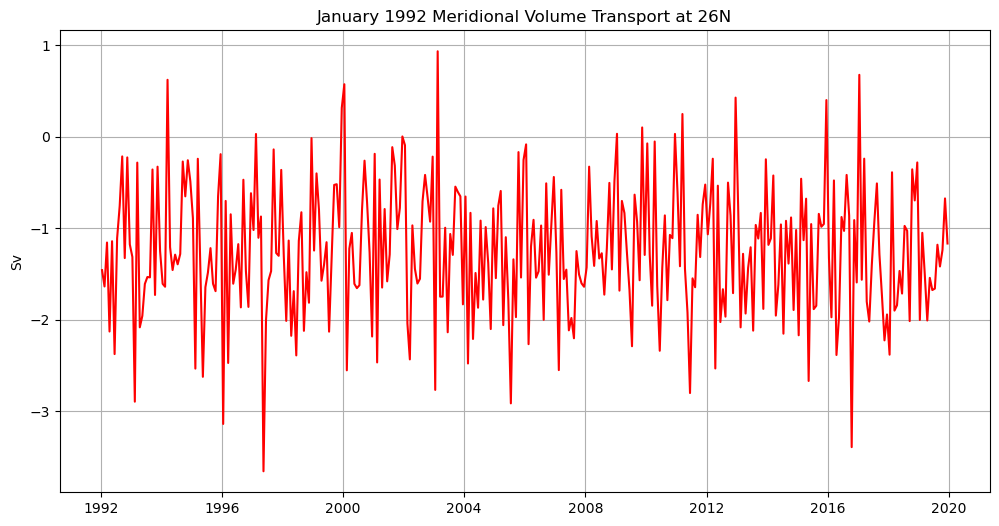

In [99]:
plt.figure(figsize=(12,6))
plt.plot(mvt['time'],mvt.vol_trsp,'r')
plt.grid()
plt.title('January 1992 Meridional Volume Transport at 26N')
plt.ylabel('Sv')
plt.show()

In [ ]:
strm = ecco.calc_meridional_stf(ecco_ds,lat_vals=26,basin_name='atlExt')

In [ ]:
strm.compute()

In [18]:
sel_ds = ecco_ds.where(ecco_ds['time'].dt.year==1992,drop=True)
sel_ds

<xarray.Dataset> Size: 517MB
Dimensions:   (k: 50, time: 12, tile: 13, j: 90, i_g: 90, j_g: 90, i: 90)
Coordinates:
  * i         (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g       (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j         (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k         (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile      (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC        (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC        (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG        (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG        (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z         (k) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
  * time      (time) datetime64[ns] 96B 1992-01-16T18:00:00 ... 1992-12-16T12...
Data variables:
    drF       (k, time) float32 2kB 10.0 10.0 10.0 10.0 ... 456.5 456.5 456.5
    dyG       (tile, j, i_g, time) float32 5MB 2.321e+04 2.321e+04 ... 1.558e+04
    dxG       (tile, j_g, i, time) float32 5MB 1.558e+04 1.558e+04 ... 2.314e+04
    UVELMASS  (time, k, tile, j, i_g) float32 253MB dask.array<chunksize=(1, 25, 13, 90, 45), meta=np.ndarray>
    VVELMASS  (time, k, tile, j_g, i) float32 253MB dask.array<chunksize=(1, 25, 13, 45, 90), meta=np.ndarray>
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

In [20]:
#ecco_ds_92 = ecco_ds.isel(time=0)
lat_range = np.arange(-30,80,1)
strm_full= ecco.calc_meridional_stf(sel_ds,lat_vals=lat_range,basin_name='atlExt')

get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] /home/jovyan/ECCOv4-py/binary_data
load_binary_array: loading file /home/jovyan/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] /home/jovyan/ECCOv4-py/binary_data
load_binary_array: loading file /home/jovyan/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/core.py:5039: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/notebook/lib/py

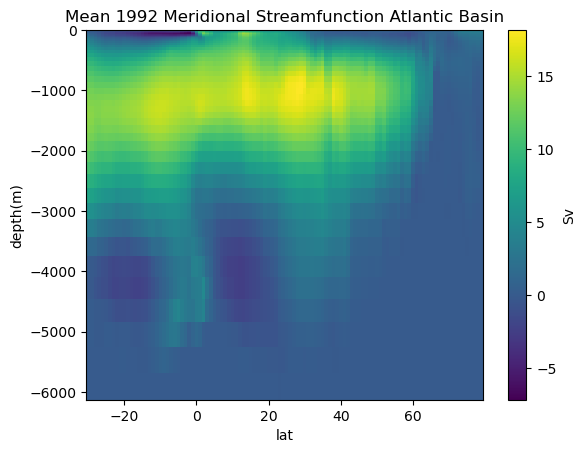

In [22]:
plt.pcolormesh(strm_full.lat,strm_full.Z,strm_full.psi_moc.mean('time'))
cb=plt.colorbar()
cb.set_label('Sv')
plt.title('Mean 1992 Meridional Streamfunction Atlantic Basin')
plt.ylabel('depth(m)')
plt.xlabel('lat')
plt.show()

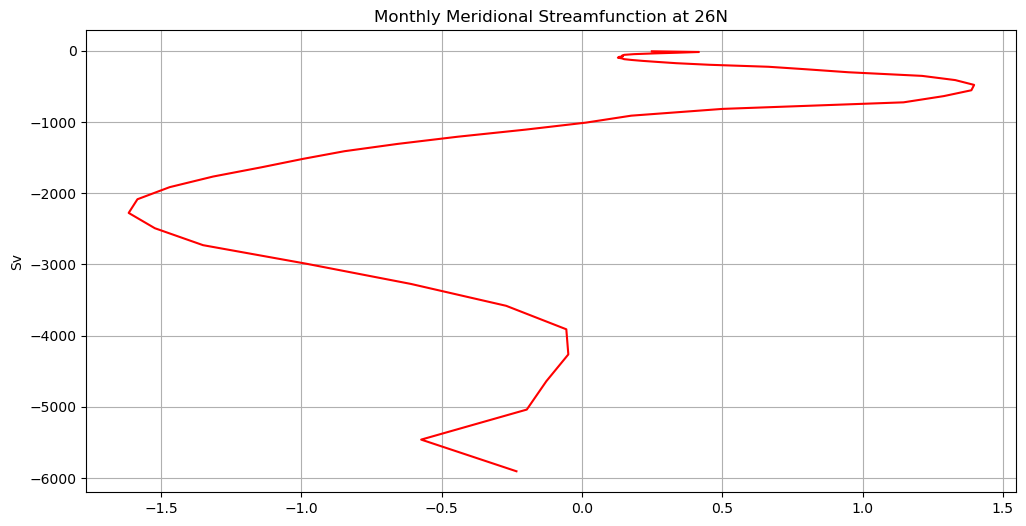

In [69]:
plt.figure(figsize=(12,6))
plt.plot(strm.trsp_z[0,:,:],strm['Z'],'r')
plt.grid()
plt.title('Monthly Meridional Streamfunction at 26N')
plt.ylabel('Sv')
plt.show()

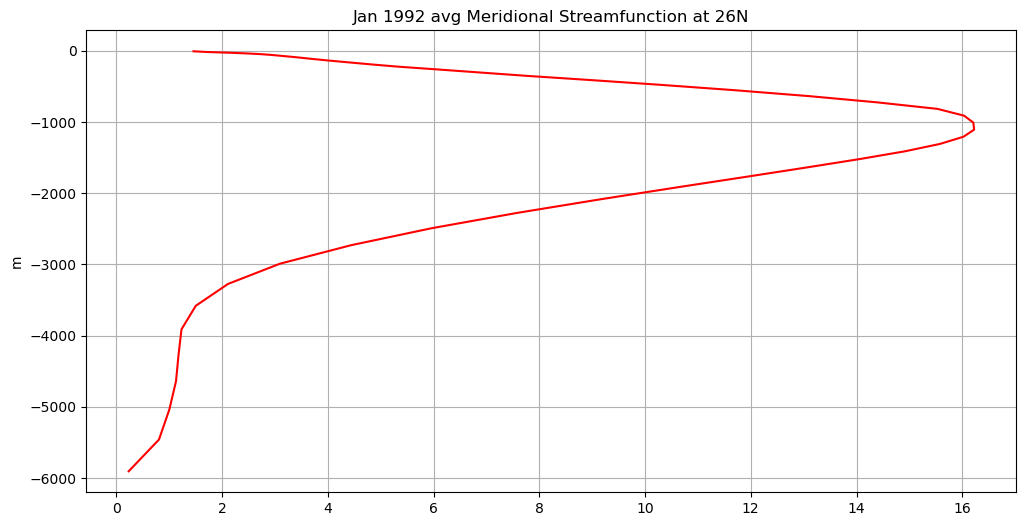

In [110]:
plt.figure(figsize=(12,6))
plt.plot(strm.psi_moc[0,:,:],strm['Z'],'r')
plt.grid()
plt.title('Jan 1992 avg Meridional Streamfunction at 26N')
plt.ylabel('m')
plt.show()

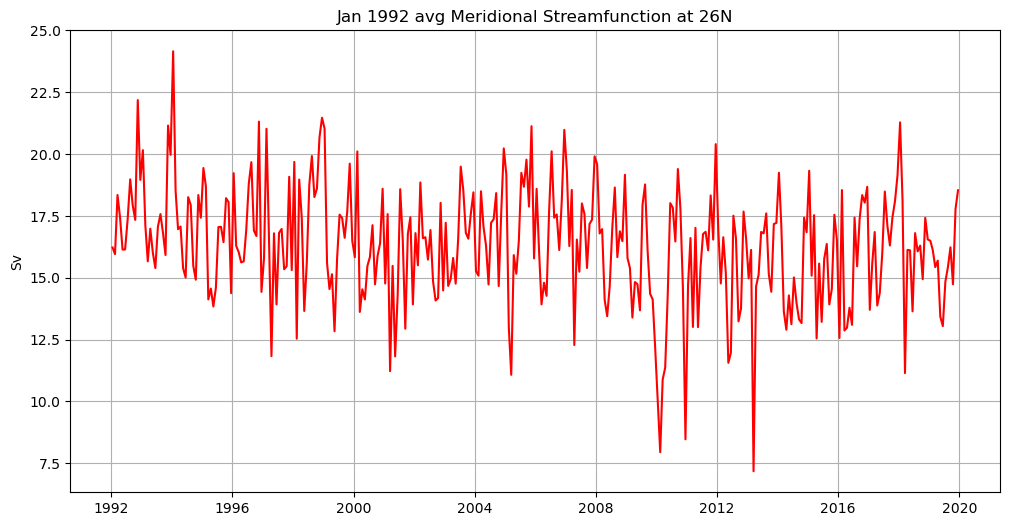

In [112]:
plt.figure(figsize=(12,6))
plt.plot(strm['time'],strm.moc,'r')
plt.grid()
plt.title('Jan 1992 avg Meridional Streamfunction at 26N')
plt.ylabel('Sv')
plt.show()

In [ ]:
ds_dens.RHOAnoma

Text(0.5, 1.0, 'Mean Ocean Density from 0-10m 01-1992')

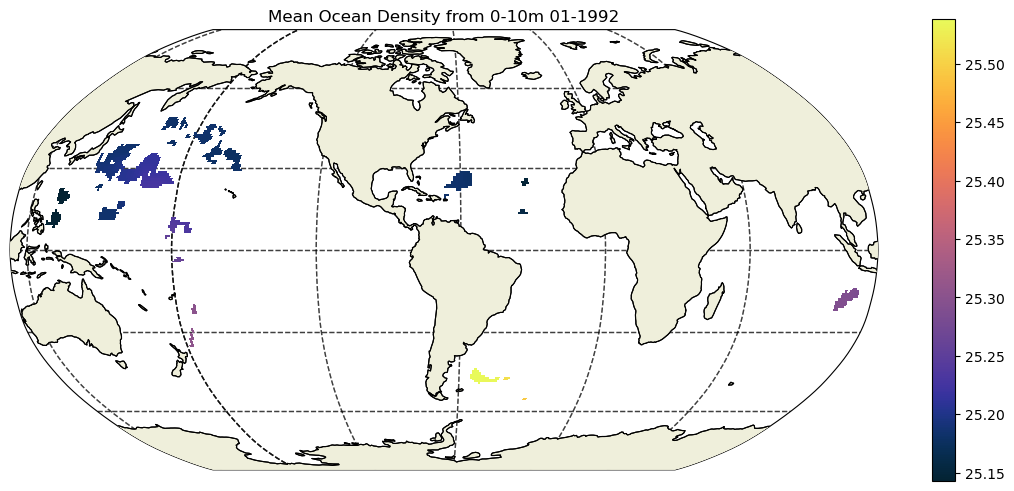

In [96]:
plt.figure(figsize=[14,6]);

ecco.plot_proj_to_latlon_grid(ds_dens.XC, ds_dens.YC, 
                              ds_dens.RHOAnoma[1,49,:,:,:], 
                              user_lon_0=-67, show_colorbar=True,
                              cmap=cmocean.cm.thermal);

plt.title('Mean Ocean Density from 0-10m 01-1992')

In [100]:
ecco_ds

<xarray.Dataset> Size: 14GB
Dimensions:   (k: 50, tile: 13, j: 90, i_g: 90, j_g: 90, i: 90, time: 336)
Coordinates:
  * i         (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g       (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j         (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k         (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile      (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC        (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC        (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG        (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG        (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z         (k) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
  * time      (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
Data variables:
    drF       (k) float32 200B ...
    dyG       (tile, j, i_g) float32 421kB ...
    dxG       (tile, j_g, i) float32 421kB ...
    UVELMASS  (time, k, tile, j, i_g) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 45), meta=np.ndarray>
    VVELMASS  (time, k, tile, j_g, i) float32 7GB dask.array<chunksize=(1, 25, 13, 45, 90), meta=np.ndarray>
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

In [116]:
strm2 = ecco.calc_meridional_stf(ecco_ds,lat_vals=26,basin_name='atlExt',doFlip=False)

get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] /home/jovyan/ECCOv4-py/binary_data
load_binary_array: loading file /home/jovyan/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['atl', 'mexico', 'hudson', 'med', 'north', 'baffin', 'gin'] /home/jovyan/ECCOv4-py/binary_data
load_binary_array: loading file /home/jovyan/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/core.py:5039: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/srv/conda/envs/notebook/lib/py

In [117]:
strm2.compute()

<xarray.Dataset> Size: 275kB
Dimensions:  (k: 50, lat: 1, time: 336)
Coordinates:
    Z        (k) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * lat      (lat) int64 8B 26
  * time     (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
Data variables:
    trsp_z   (time, k, lat) float64 134kB 0.2492 0.417 ... -0.1323 -0.07825
    psi_moc  (time, k, lat) float64 134kB 0.2492 0.6662 1.007 ... -1.09 -1.168
    moc      (time, lat) float64 3kB 14.77 14.32 17.19 15.32 ... 13.5 17.1 17.37

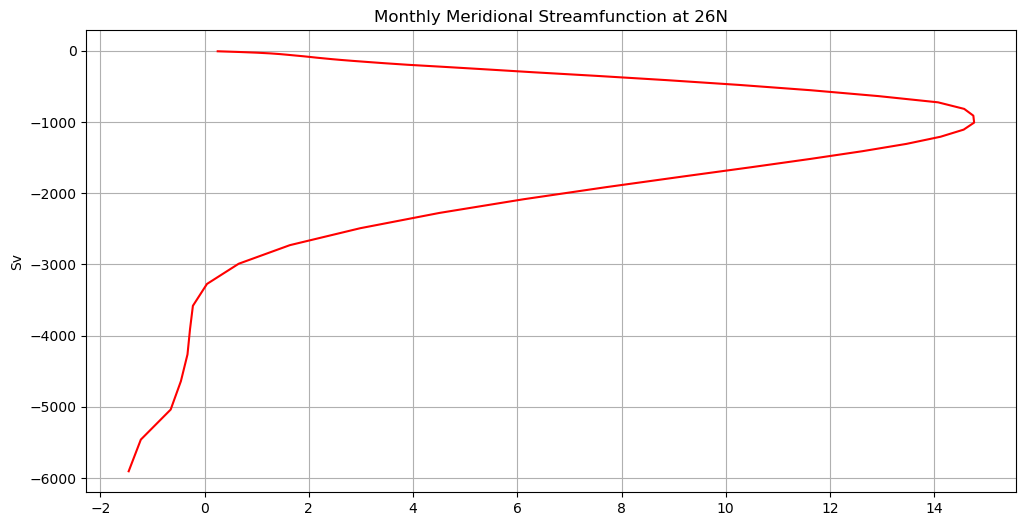

In [119]:
plt.figure(figsize=(12,6))
plt.plot(strm2.psi_moc[0,:,:],strm2['Z'],'r')
plt.grid()
plt.title('Monthly Meridional Streamfunction at 26N')
plt.ylabel('Sv')
plt.show()

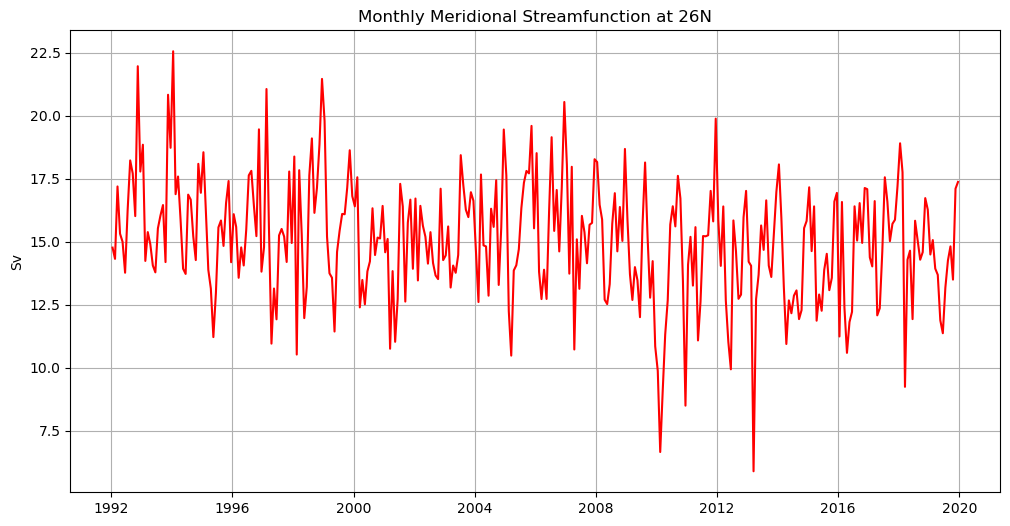

In [120]:
plt.figure(figsize=(12,6))
plt.plot(strm2['time'],strm2.moc,'r')
plt.grid()
plt.title('Monthly Meridional Streamfunction at 26N')
plt.ylabel('Sv')
plt.show()

In [128]:
MOc_avg = strm.psi_moc.mean(dim = 'time')
Moc_avg2 = strm2.psi_moc.mean(dim = 'time')

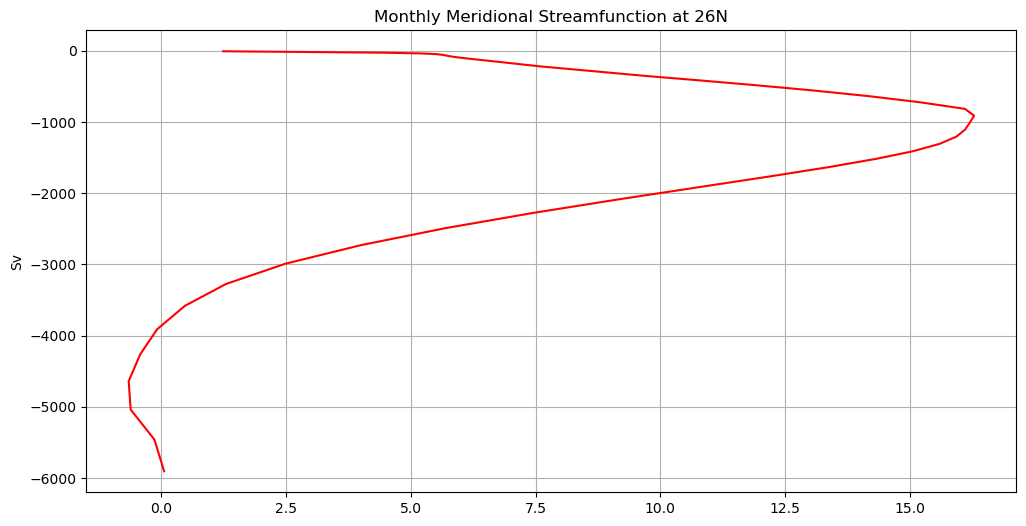

In [127]:
plt.figure(figsize=(12,6))
plt.plot(MOc_avg,strm['Z'],'r')
plt.grid()
plt.title('Monthly Meridional Streamfunction at 26N')
plt.ylabel('Sv')
plt.show()

In [238]:
strm = ecco.calc_meridional_stf(ecco_ds,lat_vals=26)

KeyError: "No variable named 'UVELMASS'. Variables on the dataset include ['i', 'i_g', 'j', 'j_g', 'k', ..., 'Z_bnds', 'ocean_column_thickness', 'ice_shelf_draft', 'time', 'RHOAnoma']"

In [131]:
MOc_avg = strm.psi_moc.mean(dim = 'time')

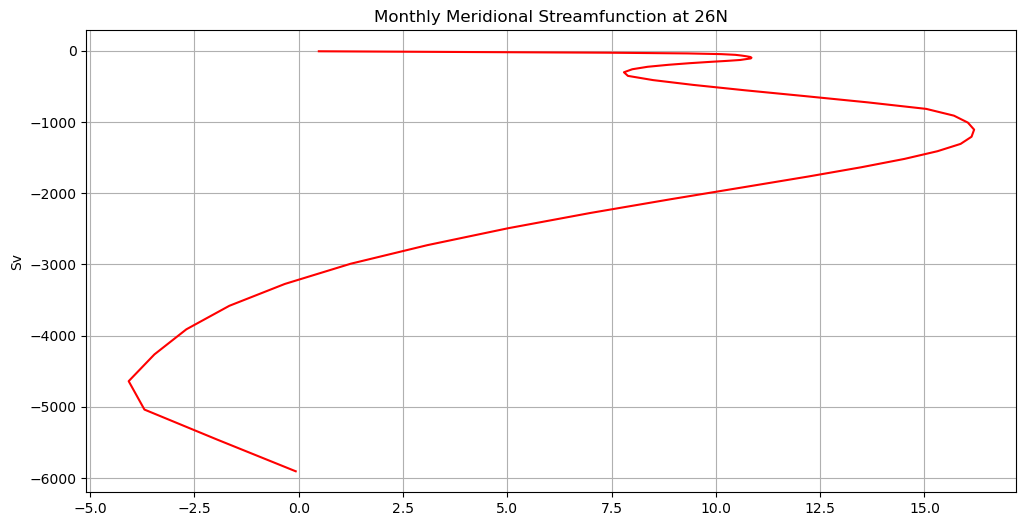

In [132]:
plt.figure(figsize=(12,6))
plt.plot(MOc_avg,strm['Z'],'r')
plt.grid()
plt.title('Monthly Meridional Streamfunction at 26N')
plt.ylabel('Sv')
plt.show()

In [139]:
strm.trsp_z.sum(dim='k').mean(dim = 'time')

<xarray.DataArray 'trsp_z' (lat: 1)> Size: 8B
array([-0.4824325])
Coordinates:
  * lat      (lat) int64 8B 26

In [23]:
ecco_ds = xr.merge((ds_geom , ds_dens['RHOAnoma']))

In [193]:
ds_geom.load()

<xarray.Dataset> Size: 92MB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2)
Coordinates: (12/20)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zp1                     (k_p1) float32 204B 0.0 -10.0 ... -6.134e+03
    Zu                      (k_u) float32 200B -10.0 -20.0 ... -6.134e+03
    Zl                      (k_l) float32 200B 0.0 -10.0 ... -5.678e+03
    XC_bnds                 (tile, j, i, nbh) float32 2MB -115.0 ... -108.5
    YC_bnds                 (tile, j, i, nbh) float32 2MB -88.18 ... -88.16
    Z_bnds                  (k, nv) float32 400B 0.0 -10.0 ... -6.134e+03
Dimensions without coordinates: nbh, nv
Data variables: (12/29)
    CS                      (tile, j, i) float32 421kB 0.06158 ... -0.9984
    SN                      (tile, j, i) float32 421kB -0.9981 ... -0.05718
    rA                      (tile, j, i) float32 421kB 3.623e+08 ... 3.611e+08
    dxG                     (tile, j_g, i) float32 421kB 1.558e+04 ... 2.314e+04
    dyG                     (tile, j, i_g) float32 421kB 2.321e+04 ... 1.558e+04
    Depth                   (tile, j, i) float32 421kB 0.0 0.0 0.0 ... 0.0 0.0
    ...                      ...
    dyF                     (tile, j, i) float32 421kB 2.324e+04 ... 1.558e+04
    dyU                     (tile, j_g, i_g) float32 421kB 1.155e+04 ... 1.55...
    rLowC                   (tile, j, i) float32 421kB 0.0 0.0 0.0 ... 0.0 0.0
    rSurfC                  (tile, j, i) float32 421kB 0.0 0.0 0.0 ... 0.0 0.0
    ocean_column_thickness  (tile, j, i) float32 421kB 0.0 0.0 0.0 ... 0.0 0.0
    ice_shelf_draft         (tile, j, i) float32 421kB -0.0 -0.0 ... -0.0 -0.0
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

In [190]:
# Get array of 1's at and north of latitude
lat = 36.5
ones = xr.ones_like(ds.YC)
dome_maskC = ones.where(ds.YC>=lat,0).compute()

In [194]:
maskC = ds_geom.maskC.compute()
maskS = ds_geom.maskS.compute()
maskW = ds_geom.maskW.compute()

<Figure size 1200x600 with 0 Axes>

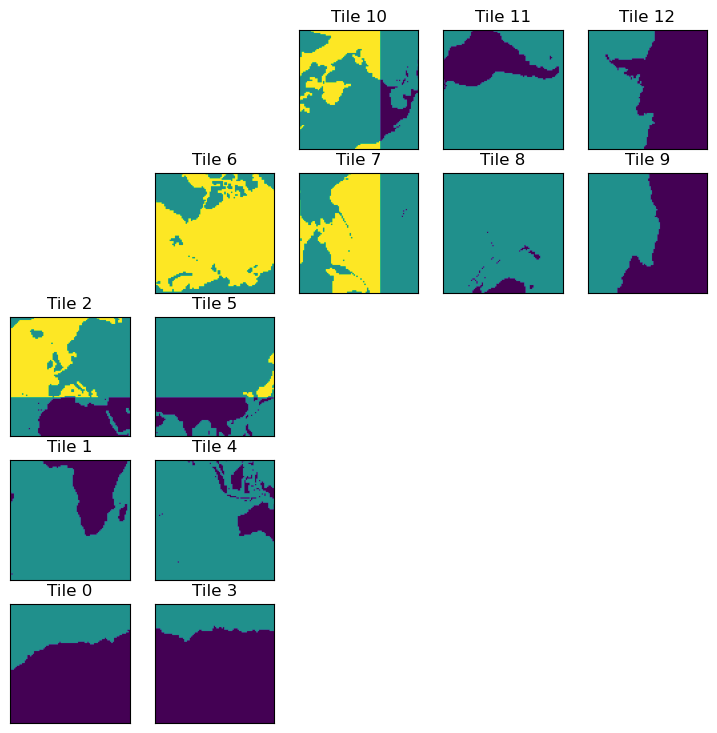

In [195]:
plt.figure(figsize=(12,6))
ecco.plot_tiles(dome_maskC+maskC.isel(k=0), cmap='viridis');

In [196]:
grid = ecco.get_llc_grid(ecco_ds)

In [197]:
lat_maskW = grid.diff(dome_maskC,'X',boundary='fill')
lat_maskS = grid.diff(dome_maskC,'Y',boundary='fill')

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [198]:
exp_mask = np.abs(lat_maskW.values + lat_maskS.values)
exp_mask = np.where(np.abs(exp_mask)>0, 1, 0)

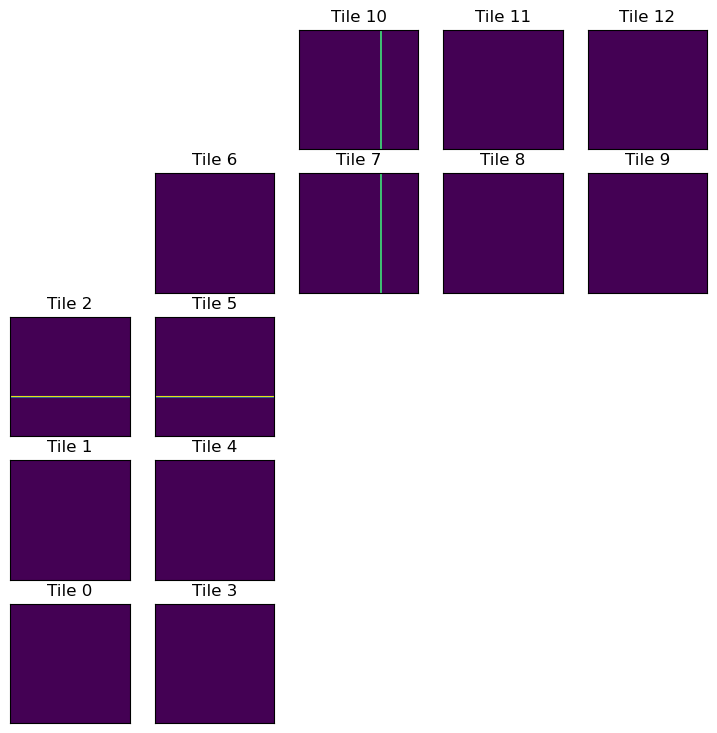

In [200]:
ecco.plot_tiles(exp_mask)
exp_mask_DA = ds['THETA'][0][0]*0; 
exp_mask_DA.name = 'exp_mask'
exp_mask_DA.values = exp_mask
exp_mask_DA;

In [201]:
# ian is tired
exp_2D_xy_slice = ds['THETA'][0][0] * exp_mask_DA;

In [202]:
exp_mask_ins = np.where(exp_mask_DA.values.ravel() > 0)[0]
print(len(exp_mask_ins))

360


In [212]:
tt_lons = ds.XC.values.ravel()[exp_mask_ins]

In [213]:
tts = []
for k in range(50):
    tt =ds['THETA'][0][k].values.ravel()[exp_mask_ins]
    tts.append(tt)

print(len(tts))
tts = np.array(tts)
tts.shape

50


(50, 360)

/tmp/ipykernel_103/3494063029.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(tt_lons, ds.Z, tts)


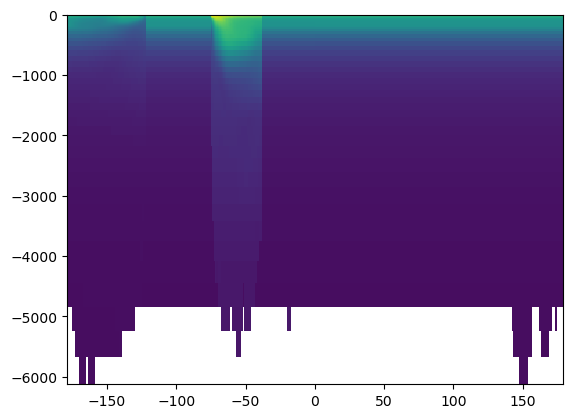

In [215]:
plt.pcolormesh(tt_lons, ds.Z, tts)

In [219]:
tts.shape

(50, 360)

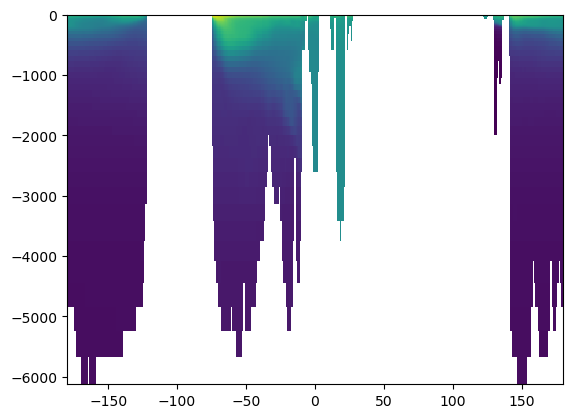

In [220]:
lon_indices = np.argsort(tt_lons)

plt.pcolormesh(tt_lons[lon_indices], ds.Z, tts[:,lon_indices])

In [55]:
lat_maskW+maskW.isel(k=0)

<xarray.DataArray (tile: 13, j: 90, i_g: 90)> Size: 421kB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 1.],
        [1., 1., 1., ..., 0., 0., 1.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
...
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * i_g      (i_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    k        int32 4B 0
    Z        float32 4B -5.0

In [52]:
density = ds_dens['RHOAnoma']
density.isel(k=0).isel(time=0)

<xarray.DataArray 'RHOAnoma' (tile: 13, j: 90, i: 90)> Size: 421kB
dask.array<getitem, shape=(13, 90, 90), dtype=float32, chunksize=(13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
    k        int32 4B 0
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    time     datetime64[ns] 8B 1992-01-16T18:00:00
    XC       (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC       (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z        float32 4B dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    valid_min:              -12.423014
    valid_max:              25.538467
    coverage_content_type:  modelResult
    long_name:              In-situ seawater density anomaly
    units:                  kg m-3
    comment:                In-situ seawater density anomaly relative to the ...

In [53]:
ds_vel

<xarray.Dataset> Size: 21GB
Dimensions:    (time: 336, k: 50, tile: 13, j: 90, i_g: 90, j_g: 90, i: 90,
                k_l: 50, k_u: 50, k_p1: 51, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 5kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    UVELMASS   (time, k, tile, j, i_g) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 45), meta=np.ndarray>
    VVELMASS   (time, k, tile, j_g, i) float32 7GB dask.array<chunksize=(1, 25, 13, 45, 90), meta=np.ndarray>
    WVELMASS   (time, k_l, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Volume Fluxes - Monthly Mean ...
    uuid:                            b2c0cc44-271c-11f0-9807-0a58a9feac02

(<Figure size 900x900 with 25 Axes>,
 array([[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]]))

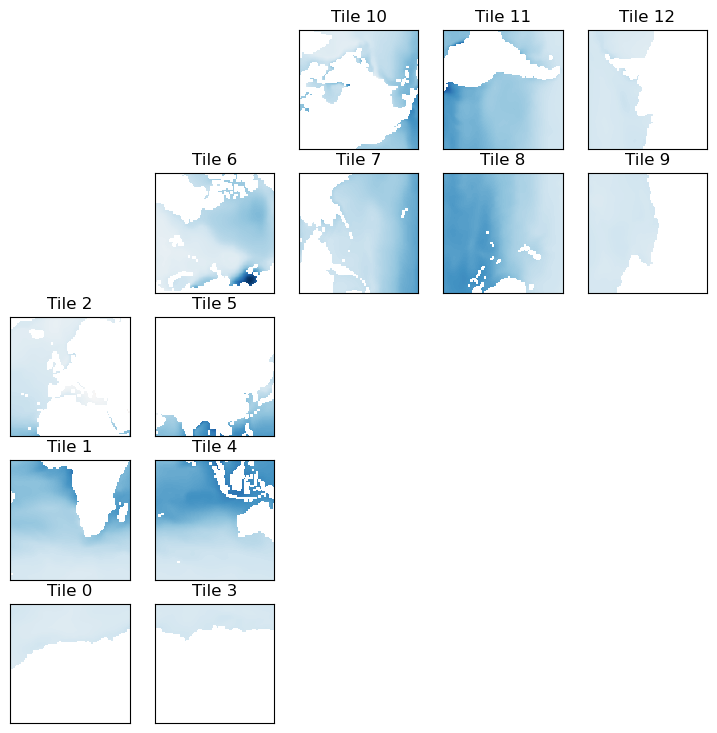

In [56]:
ecco.plot_tiles(density.isel(k=0).isel(time=0))

In [98]:
vel_trial = ds_vel.UVELMASS[0,:,10,70,70].load()
rho_trial = density[0,:,10,70,70].load()
vel_trial

<xarray.DataArray 'UVELMASS' (k: 50)> Size: 200B
array([ 7.5072558e-03,  8.9498470e-03,  9.5804613e-03,  9.4900541e-03,
        9.1728410e-03,  8.9691877e-03,  8.8081881e-03,  9.0194363e-03,
        9.1468068e-03,  6.6166366e-03,  7.0488453e-03,  4.8515508e-03,
        4.7395062e-03,  4.2650881e-03,  4.0693129e-03,  4.0845419e-03,
        3.8529539e-03,  3.6892081e-03,  3.5300050e-03,  3.2373525e-03,
        2.8546450e-03,  2.4205660e-03,  1.8763297e-03,  1.1523556e-03,
        4.0766783e-04, -5.6970839e-05, -2.0840837e-04, -2.3615023e-04,
       -2.0992062e-04, -1.0725260e-04,  5.0099428e-05,  2.3152106e-04,
        4.2724534e-04,  5.9097062e-04,  6.4785097e-04,  5.0674879e-04,
        1.5649668e-04, -2.1014659e-04, -3.7484945e-04, -1.7267998e-04,
        3.1854218e-04,  8.3163689e-04,  1.2888248e-03,  1.6075301e-03,
        1.7539698e-03,  1.8234412e-03,  1.6643131e-03,  1.2980072e-03,
        1.1181389e-03,            nan], dtype=float32)
Coordinates:
    i_g      int32 4B 70
    j        int32 4B 70
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    tile     int32 4B 10
    time     datetime64[ns] 8B 1992-01-16T18:00:00
    Z        (k) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
Attributes:
    valid_min:              -0.71189505
    valid_max:              0.8394877
    coverage_content_type:  modelResult
    direction:              >0 increases volume
    long_name:              Horizontal velocity in the model +x direction per...
    units:                  m s-1
    comment:                Horizontal velocity in the model +x direction ave...

In [99]:
target_sig_levels = np.arange(-11,26,.5)

In [100]:
vel_dens = np.interp(target_sig_levels, rho_trial.values, vel_trial.values,left= np.nan,right= np.nan)

In [101]:
vel_dens

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
        8.43581921e-03,  4.81544137e-03,  4.08199316e-03,  3.55238551e-03,
        2.93249291e-03,  2.29615536e-03,  1.61591164e-03,  9.08858960e-04,
        3.05196743e-04, -7.16684061e-05, -2.05845810e-04, -2.32853272e-04,
       -2.15423949e-04, -1.36552440e-04, -3.73271935e-06,  1.62265013e-04,
        3.46363288e-04,  5.16503616e-04,  6.17529818e-04,  6.01414158e-04,
        4.62895262e-04,  2.11381478e-04, -2.43133813e-05, -2.28262528e-04,
       -3.20456104e-04, -3.33122096e-04, -2.31350392e-04, -7.68996684e-05,
        1.49258874e-04,  3.73419266e-04,  5.91632366e-04,  8.09845465e-04,
        9.93698951e-04,  1.17374051e-03,  1.33093380e-03,  1.44764696e-03,
        1.56436011e-03,  

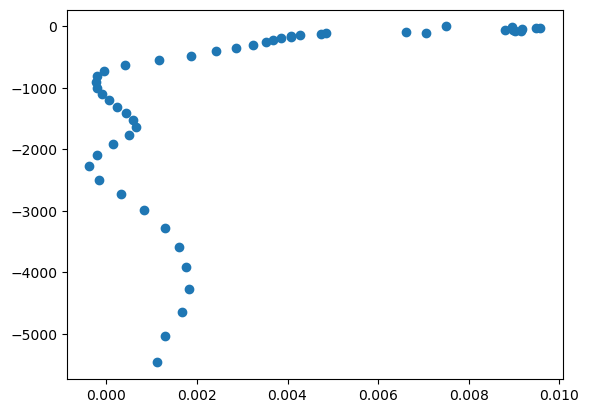

In [102]:
plt.scatter(vel_trial,vel_trial.Z)

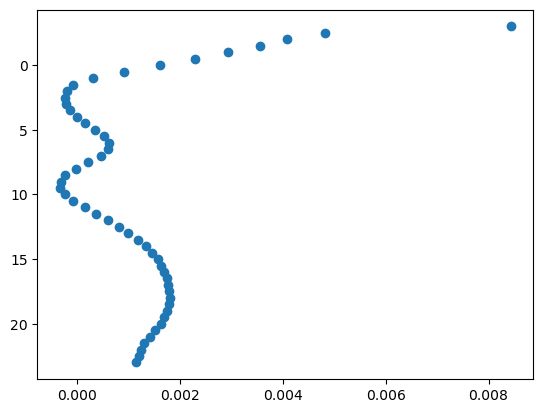

In [103]:
plt.scatter(vel_dens,target_sig_levels)
plt.gca().invert_yaxis()

In [107]:
Uvel_an_mean = ds_vel.UVELMASS                     

ValueError: 'time.year' not found in array dimensions ('time', 'k', 'tile', 'j', 'i_g')

In [30]:
ds_vel_clim = ds_vel.groupby("time.month").mean('time')

In [31]:
ds_vel_clim

<xarray.Dataset> Size: 763MB
Dimensions:   (month: 12, k: 50, tile: 13, j: 90, i_g: 90, j_g: 90, i: 90,
               k_l: 50, k_u: 50, k_p1: 51, nb: 4, nv: 2)
Coordinates: (12/21)
  * i         (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g       (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j         (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k         (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u       (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...        ...
    Zu        (k_u) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    Zl        (k_l) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
    XC_bnds   (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds   (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds    (k, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nb, nv
Data variables:
    UVELMASS  (month, k, tile, j, i_g) float32 253MB dask.array<chunksize=(1, 25, 13, 90, 45), meta=np.ndarray>
    VVELMASS  (month, k, tile, j_g, i) float32 253MB dask.array<chunksize=(1, 25, 13, 45, 90), meta=np.ndarray>
    WVELMASS  (month, k_l, tile, j, i) float32 253MB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Volume Fluxes - Monthly Mean ...
    uuid:                            b2c0cc44-271c-11f0-9807-0a58a9feac02

In [ ]:
vel_trial = ds_vel.UVELMASS[0,:,10,70,70].load()
rho_trial = density[0,:,10,70,70].load()
for 

vel_dens = np.interp(target_sig_levels, rho_trial.values, vel_trial.values,left= np.nan,right= np.nan)

In [71]:
dims = ("k", "tile", "i", "j")
coords = {
    "k": density.k,
    "tile": density.tile,
    "i": density.j,
    "j": density.i,
    "Z":density.Z,
    "XC":density.XC,
    "YC":density.YC,
}

# Create xarray DataArray
sig2 = xr.DataArray(sigma_2, dims=dims, coords=coords)

In [70]:
density

<xarray.DataArray 'RHOAnoma' (time: 336, k: 50, tile: 13, j: 90, i: 90)> Size: 7GB
dask.array<concatenate, shape=(336, 50, 13, 90, 90), dtype=float32, chunksize=(1, 25, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
    XC       (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC       (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z        (k) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
Attributes:
    valid_min:              -12.423014
    valid_max:              25.538467
    coverage_content_type:  modelResult
    long_name:              In-situ seawater density anomaly
    units:                  kg m-3
    comment:                In-situ seawater density anomaly relative to the ...

In [73]:
sig2.shape

(50, 13, 90, 90)

In [76]:
sigma_edge = np.arange(-11,26.5,.5)
sigma_mid = np.arange(-10.75,26.25,.5)
iso_temp = np.histogram(sig2, bins=[sigma_edge], dim=['k'], density=False)
iso_count = iso_temp.rename({'sigma_bin':signame}).assign_coords({signame:sigma_mid})

TypeError: histogram() got an unexpected keyword argument 'dim'